In [5]:
##Xử lý dữ liệu

#Import thư viện
import re, regex as re2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display
plt.style.use("seaborn-v0_8"); sns.set_palette("Set2")  #Định dạng bảng

#Tải dữ liệu bảng CSV từ github
dataset_url = "https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/data/all_tickets_processed_improved_v3.csv"
raw_data = pd.read_csv(dataset_url)
raw_data = raw_data.replace({r'â€‰':'', r'\u2009':''}, regex=True)  #Làm sạch dữ liệu

#In thử 5 dòng đầu
raw_data.head(5)

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [6]:
#Kiểm tra số lượng mẫu và thuộc tính gốc của dữ liệu
print ("Số lượng mẫu có trong dataset là:", raw_data.shape[0])
print ("Số lượng thuộc tính có trong dataset là:", raw_data.shape[1])

Số lượng mẫu có trong dataset là: 47837
Số lượng thuộc tính có trong dataset là: 2


Document       0
Topic_group    0
dtype: int64
Duplicates: 0
text_col: Document label_col: Topic_group


,count
Topic_group,
Hardware,13617
HR Support,10915
Access,7125
Miscellaneous,7060
Storage,2777


count    47837.000000
mean        43.597341
std         56.736800
min          2.000000
25%         17.000000
50%         26.000000
75%         46.000000
max        981.000000
Name: Document, dtype: float64


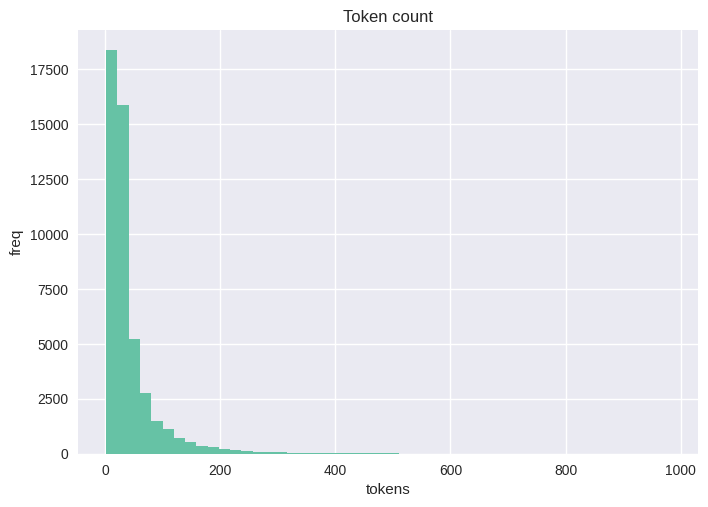

In [7]:
# Kiểm tra dữ liệu null và trùng lặp
print(raw_data.isna().sum().sort_values(ascending=False).head())
print("Duplicates:", raw_data.duplicated().sum())

# Xác định cột văn bản và cột nhãn
obj_cols = [c for c in raw_data.columns if raw_data[c].dtype=='object']
text_col = max(obj_cols, key=lambda c: raw_data[c].astype(str).str.len().mean())
label_col = [c for c in raw_data.columns if c != text_col][0]  # dataset có 2 cột

print("text_col:", text_col, "label_col:", label_col)

# Thống kê phân phối nhãn
vc = raw_data[label_col].value_counts()
display(vc.head()); (vc/vc.sum()).head()

# Thống kê độ dài văn bản
lens = raw_data[text_col].astype(str).str.split().map(len)
print(lens.describe())
plt.figure(); lens.hist(bins=50); plt.title('Token count'); plt.xlabel('tokens'); plt.ylabel('freq'); plt.show()

# Đề xuất max_len và vocab_limit
max_len = int(np.percentile(lens, 95))  # gợi ý
vocab_limit = 30000

**Nhận xét về dữ liệu**

*Tính sạch của dữ liệu*

- Không có giá trị bị thiếu (NaN).

- Không có dòng trùng lặp.

-> Dữ liệu gốc rất sạch, không cần xử lý thiếu/trùng.

*Cột dữ liệu*

- Document: cột chứa văn bản (mô tả sự cố IT).

- Topic_group: cột nhãn phân loại (loại sự cố).

*Phân phối nhãn*

- 5 nhóm chính:

- Hardware: 13,617 mẫu

- HR Support: 10,915 mẫu

- Access: 7,125 mẫu

- Miscellaneous: 7,060 mẫu

- Storage: 2,777 mẫu

-> Các nhãn hơi mất cân bằng: Hardware nhiều gấp gần 5 lần Storage.
Cần lưu ý khi huấn luyện mô hình (có thể dùng class weights).

*Độ dài văn bản*

- Trung bình: ~44 từ.

- Median (50% dữ liệu): 26 từ.

- 75% dữ liệu: ≤ 46 từ.

- Văn bản dài nhất: 981 từ.

-> Biểu đồ histogram cho thấy đa số văn bản rất ngắn (<50 từ), chỉ một số ít cực dài → phân phối lệch phải (skewed).

*Tham số tiền xử lý đề xuất*

- max_len = ~120 (percentile 95) -> đủ bao phủ 95% dữ liệu, tránh bị outlier kéo dài.

- vocab_limit = 30,000 -> giới hạn từ vựng cho tokenizer, cân bằng giữa hiệu quả và tài nguyên.

In [8]:
#Chia train 80%, test 10%, validation 10%
from sklearn.model_selection import train_test_split
train, test = train_test_split(raw_data, test_size=0.1, stratify=raw_data[label_col], random_state=42)
train, val  = train_test_split(train,    test_size=0.1, stratify=train[label_col],    random_state=42)

In [9]:
#Import thư viện
!pip -q install emoji unidecode
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
from emoji import replace_emoji
from unidecode import unidecode
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
class TextPreprocessor:
    def __init__(self, lower=True, strip_accents=False,
                 remove_urls=True, remove_emojis=True,
                 remove_special=True, remove_numbers=False,
                 remove_stopwords=True, stop_lang='english',
                 max_words=30000, max_len=128, oov_token='<OOV>'):
        # Thiết lập tham số tiền xử lý
        self.lower=lower; self.strip_accents=strip_accents
        self.remove_urls=remove_urls; self.remove_emojis=remove_emojis
        self.remove_special=remove_special; self.remove_numbers=remove_numbers
        self.remove_stopwords=remove_stopwords
        self.stop=set(stopwords.words(stop_lang)) if remove_stopwords else set()
        # Tokenizer để biến từ thành số
        self.tok=Tokenizer(num_words=max_words, oov_token=oov_token)
        self.max_len=max_len

    def _clean(self, s):
        # Làm sạch 1 câu văn bản
        if not isinstance(s,str): s=str(s)
        if self.lower: s=s.lower()
        if self.strip_accents: s=unidecode(s)
        if self.remove_urls: s=re.sub(r'(http\S+|www\.\S+|[\w\.-]+@[\w\.-]+|@\w+|#\w+)', ' ', s)
        if self.remove_emojis: s=replace_emoji(s, replace='')
        if self.remove_special: s=re2.sub(r"[^\p{L}\p{N}\s]", " ", s)
        if self.remove_numbers: s=re.sub(r"\d+", " ", s)
        toks=re.findall(r"\w+", s, flags=re.UNICODE)
        if self.stop: toks=[t for t in toks if t not in self.stop]
        return " ".join(toks)

    def fit(self, texts):
        # Làm sạch + xây dựng từ điển từ train
        cleaned=[self._clean(t) for t in texts]
        self.tok.fit_on_texts(cleaned)
        return cleaned

    def transform(self, texts):
        # Làm sạch + chuyển văn bản thành số + padding
        cleaned=[self._clean(t) for t in texts]
        seq=self.tok.texts_to_sequences(cleaned)
        pad=pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

    def fit_transform(self, texts):
        # Kết hợp fit và transform cho tập train
        cleaned=self.fit(texts)
        seq=self.tok.texts_to_sequences(cleaned)
        pad=pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

In [11]:
# Khởi tạo bộ tiền xử lý với tham số đã chọn
tp = TextPreprocessor(
    lower=True,
    strip_accents=False,
    remove_urls=True,
    remove_emojis=True,
    remove_special=True,
    remove_numbers=False,     # giữ lại số (mã lỗi, version có thể quan trọng)
    remove_stopwords=True,
    stop_lang='english',
    max_words=vocab_limit,    # giới hạn từ vựng
    max_len=max_len           # chiều dài chuỗi sau padding
)

# Tiền xử lý văn bản -> chuyển thành chuỗi số đã padding
Xtr,_ = tp.fit_transform(train[text_col].astype(str))   # fit trên train
Xva,_ = tp.transform(val[text_col].astype(str))         # transform val
Xte,_ = tp.transform(test[text_col].astype(str))        # transform test

# Mã hóa nhãn (chữ -> số)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ytr = le.fit_transform(train[label_col])   # fit trên train
yva = le.transform(val[label_col])         # transform val
yte = le.transform(test[label_col])        # transform test

# Kiểm tra kích thước dữ liệu và số lớp nhãn
Xtr.shape, Xva.shape, Xte.shape, len(le.classes_)

((38747, 136), (4306, 136), (4784, 136), 8)

In [12]:
s = train[text_col].iloc[0]         # lấy 1 văn bản gốc từ tập train
_, c = tp.transform([s])            # tiền xử lý văn bản
print("RAW:", s)                    # in ra bản gốc
print("CLEAN:", c[0])               # in ra bản đã làm sạch

RAW: stage is catalogue item removed sent friday stage catalogue item removed hello could you please have look stage set catalog item removed cannot be changed could you please amend we resolve request kind regards specialist
CLEAN: stage catalogue item removed sent friday stage catalogue item removed hello could please look stage set catalog item removed cannot changed could please amend resolve request kind regards specialist
